# Bryce's Version

## Setup

Import packages and set parameters

In [59]:
import numpy as np
from scipy.integrate import simpson, solve_ivp
import matplotlib.pyplot as plt

In [60]:
# params is a better name since these values aren't changing and is 
# consistent with the paper.
params = {
    # Some of these values differed from table 1 so I changed them.
    # I marked the changed with "#!"
    'k1': 1.45e-2,  #!
    'k2': 2.76e-1, #!
    'k3': 6.07e-3, #!
    'k4': 2.35e-4,
    'k5': 9.49e-2,
    'k6': 1.93e-1,
    'k7': 1.15e0,
    'k8': 7.27e0,
    'k9': 0,
    'k10': 0,
    'k11': 3.83e-2,
    'k12': 2.84e-1,
    # k13 wasn't defined in paper
    'sigma': 1.34e0, #!
    'KM': 2.36e2 #!
}

# These values come from the appendix
consts = {
    # The first two depend on initial conditions. Setting to "None" for safety
    'Gbpl': None,
    'Ibpl': None,
    'gbliv': 0.043,
    'Gthpl': 9,
    'vG': 17 / 70,
    'vI': 13 / 70,
    'beta': 1,
    'f': 0.005551,
    'tau_i': 31,
    # t_start not necessary
    't_int': 30, # renamed to t_end
    'tau_d': 3,
    # Removed t_start_ipnc and t_end_ipnc
    'c1': 0.1,

    # The following differ per insulin brand.
    # TODO: Put in correct values
    'h': 1,
    't_half': 1,
    'a': 1,
    'b': 1
}

## ChatGPT's Runge-Kutta 4/5 method

Prompt "Write me a python function that does the runge-kutta 4/5 method" then "Now give me an example of using it and compare it with an analytical solution".

In [61]:
import numpy as np

def runge_kutta45(f, t0, y0, h, num_steps):
    """
    Runge-Kutta 4/5 method for solving ordinary differential equations (ODEs).

    Parameters:
        f (function): The function defining the ODE dy/dt = f(t, y).
        t0 (float): The initial value of the independent variable.
        y0 (float or array-like): The initial value(s) of the dependent variable(s).
        h (float): The step size.
        num_steps (int): The number of steps to perform.

    Returns:
        tuple: Two NumPy arrays containing the values of the independent variable (t) and the dependent variable (y).
    """
    t_values = np.zeros(num_steps + 1)
    y_values = np.zeros((num_steps + 1, len(y0)))
    t_values[0] = t0
    y_values[0] = y0

    for i in range(num_steps):
        t = t_values[i]
        y = y_values[i]

        k1 = h * f(t, y)
        k2 = h * f(t + 0.25 * h, y + 0.25 * k1)
        k3 = h * f(t + 3.0 / 8.0 * h, y + 3.0 / 32.0 * k1 + 9.0 / 32.0 * k2)
        k4 = h * f(t + 12.0 / 13.0 * h, y + 1932.0 / 2197.0 * k1 - 7200.0 / 2197.0 * k2 + 7296.0 / 2197.0 * k3)
        k5 = h * f(t + h, y + 439.0 / 216.0 * k1 - 8.0 * k2 + 3680.0 / 513.0 * k3 - 845.0 / 4104.0 * k4)
        k6 = h * f(t + 0.5 * h, y - 8.0 / 27.0 * k1 + 2.0 * k2 - 3544.0 / 2565.0 * k3 + 1859.0 / 4104.0 * k4 - 11.0 / 40.0 * k5)

        y_next = y + 25.0 / 216.0 * k1 + 1408.0 / 2565.0 * k3 + 2197.0 / 4104.0 * k4 - 0.2 * k5
        z_next = y + 16.0 / 135.0 * k1 + 6656.0 / 12825.0 * k3 + 28561.0 / 56430.0 * k4 - 9.0 / 50.0 * k5 + 2.0 / 55.0 * k6

        t_values[i + 1] = t + h
        y_values[i + 1] = y_next

    return t_values, y_values


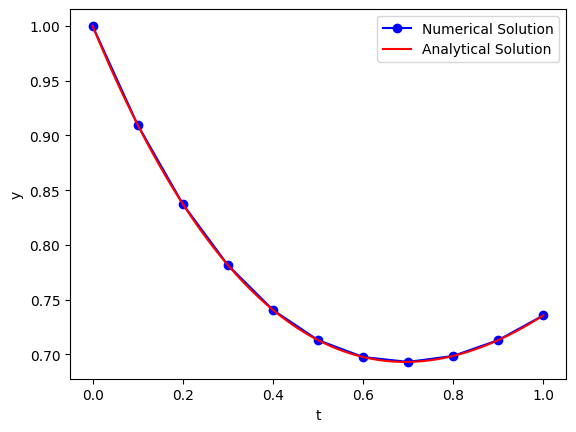

In [62]:
import numpy as np
import matplotlib.pyplot as plt

def f(t, y):
    return t - y

# Analytical solution
def analytical_solution(t):
    return t - 1 + 2 * np.exp(-t)

t0 = 0.0
y0 = [1.0]
h = 0.1
num_steps = 10

t_values, y_values = runge_kutta45(f, t0, y0, h, num_steps)

# Computing the analytical solution for comparison
t_analytical = np.linspace(t0, t0 + num_steps * h, 100)
y_analytical = analytical_solution(t_analytical)

plt.plot(t_values, y_values, 'bo-', label='Numerical Solution')
plt.plot(t_analytical, y_analytical, 'r-', label='Analytical Solution')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.show()


## Bryce's version of Delayed Runge-Kutta 4/5

I copied ChatGPT's version but I allow the function $f$ to see t_values and y_values so that the integral can be evaluated.

In [63]:
import numpy as np

def runge_kutta45_bh(f, t0, y0, h, num_steps):
    """
    Runge-Kutta 4/5 method for solving ordinary differential equations (ODEs).

    Parameters:
        f (function): The function defining the ODE dy/dt = f(t, y).
        t0 (float): The initial value of the independent variable.
        y0 (float or array-like): The initial value(s) of the dependent variable(s).
        h (float): The step size.
        num_steps (int): The number of steps to perform.

    Returns:
        tuple: Two NumPy arrays containing the values of the independent variable (t) and the dependent variable (y).
    """
    t_values = np.zeros(num_steps + 1)
    y_values = np.zeros((num_steps + 1, len(y0)))
    t_values[0] = t0
    y_values[0] = y0

    for i in range(num_steps):
        t = t_values[i]
        y = y_values[i]

        k1 = h * f(t, y, t_values, y_values)
        k2 = h * f(t + 0.25 * h, y + 0.25 * k1, t_values, y_values)
        k3 = h * f(t + 3.0 / 8.0 * h, y + 3.0 / 32.0 * k1 + 9.0 / 32.0 * k2, t_values, y_values)
        k4 = h * f(t + 12.0 / 13.0 * h, y + 1932.0 / 2197.0 * k1 - 7200.0 / 2197.0 * k2 + 7296.0 / 2197.0 * k3, t_values, y_values)
        k5 = h * f(t + h, y + 439.0 / 216.0 * k1 - 8.0 * k2 + 3680.0 / 513.0 * k3 - 845.0 / 4104.0 * k4, t_values, y_values)
        k6 = h * f(t + 0.5 * h, y - 8.0 / 27.0 * k1 + 2.0 * k2 - 3544.0 / 2565.0 * k3 + 1859.0 / 4104.0 * k4 - 11.0 / 40.0 * k5, t_values, y_values)

        y_next = y + 25.0 / 216.0 * k1 + 1408.0 / 2565.0 * k3 + 2197.0 / 4104.0 * k4 - 0.2 * k5
        z_next = y + 16.0 / 135.0 * k1 + 6656.0 / 12825.0 * k3 + 28561.0 / 56430.0 * k4 - 9.0 / 50.0 * k5 + 2.0 / 55.0 * k6

        t_values[i + 1] = t + h
        y_values[i + 1] = y_next

    return t_values, y_values


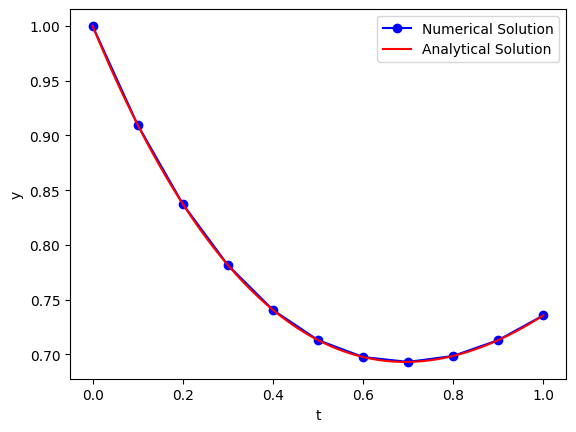

In [64]:
import numpy as np
import matplotlib.pyplot as plt

def f(t, y, t_values, y_values):
    # t_values and y_values aren't actually used, this example just shows how they
    # could be used.
    return t - y

# Analytical solution
def analytical_solution(t):
    return t - 1 + 2 * np.exp(-t)

t0 = 0.0
y0 = [1.0]
h = 0.1
num_steps = 10

t_values, y_values = runge_kutta45_bh(f, t0, y0, h, num_steps)

# Computing the analytical solution for comparison
t_analytical = np.linspace(t0, t0 + num_steps * h, 100)
y_analytical = analytical_solution(t_analytical)

plt.plot(t_values, y_values, 'bo-', label='Numerical Solution')
plt.plot(t_analytical, y_analytical, 'r-', label='Analytical Solution')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.show()


## Model Map

In [65]:
# I adjusted some of the equations. Too many spaces makes an expression hard to
# read. I use spaces for the highest level in order of operations.

# Glucose in the Gut - Why was this excluded before?
def dMGgut_dt(t, MGgut):
    def mGmeal(t):  # I switched to "t first" convention
        sigma = consts['sigma']
        k1 = consts['k1']
        Dmeal = consts['Dmeal']
        return sigma * k1**sigma * t**(sigma-1) * np.exp(-(k1*t)**sigma) * Dmeal

    def mGpl(MGgut):
        k2 = consts['k2']
        return k2 * MGgut

    return mGmeal(t) - mGpl(MGgut)

# Glucose in the plasma
def dGpl_dt(t, Gpl, Iif, MGgut): # I think Irem was a mistake?
    def gliv(Gpl, Iif):
        gbliv = consts['gbliv']
        k3 = consts['k3']
        Gbpl = consts['Gbpl']
        k4 = consts['k4']
        beta = consts['beta'] 
        return gbliv - k3*(Gpl-Gbpl) - k4*beta*Iif

    def ggut(MGgut):
        # Using the expression on the right
        k2 = consts['k2']
        f = consts['f']
        vG = consts['vG']
        Mb = consts['Mb']
        return k2 * (f/(vG*Mb)) * MGgut

    def gnonit(Gpl):
        gbliv = consts['gbliv']
        KM = consts['KM']
        Gbpl = consts['Gbpl']
        return gbliv * ((KM+Gbpl)/Gbpl) * (Gpl/(KM+Gpl))

    def git(Gpl, Iif): # I replaced Irem with Iif because I think they are the same?
        k5 = consts['k5']
        beta = consts['beta']
        KM = consts['KM']
        return k5 * beta * Iif * (Gpl/(KM+Gpl))

    def gren(Gpl):
        c1 = consts['c1']
        vG = consts['vG']
        Mb = consts['Mb']
        Gthpl = consts['Gthpl']
        return (c1/(vG*Mb)) * (Gpl-Gthpl) if Gpl > Gthpl else 0

    return gliv(Gpl, Iif) + ggut(MGgut) - gnonit(Gpl) - git(Gpl, Iif) - gren(Gpl)

# Insulin in the Plasma
"""
These two are defined seperately since their derivatives are given. However, it
should be noted their derivatives don't depend on anything else in the model so
they could be solved seperately and their solutions could be used with the rest
of the model.
""" 
def dUsc1_dt(t, Usc1):
        k10 = consts['k10']
        usa = consts['usa'](t)
        return usa - k10*Usc1

def dUsc2_dt(t, Usc1, Usc2):
        k10 = consts['k10']
        k9 = consts['k9']
        return k10*Usc1 - k9*Usc2

def dIpl_dt(t, MGgut, Gpl, Ipl, Iif, Usc1, Usc2, t_values, Gpl_values):
    def ipnc(t, Gpl, dGpl_dt_val, Gpl_values):
        beta = consts['beta']
        k6 = consts['k6']
        Gbpl = consts['Gbpl']
        k7 = consts['k7']
        tau_i = consts['tau_i']
        t_int = consts['t_int']
        k8 = consts['k8']
        tau_d = consts['tau_d']

        # TODO: Check the domain of integration! There is probably a mistake because
        # it would break causation as it is written. Try to figure out what
        # this equation was supposed to mean?
        window = t_values > t - t_int  # I'm guessing this is what was intended for the integration domain?
        integral = simpson(Gpl_values[window]-Gbpl, t_values[window]) if len(window) else 0.

        term1 = k6 * (Gpl-Gbpl)
        term2 = (k7/tau_i) * integral
        term3 = (k7/tau_i) * Gbpl
        term4 = (k8*tau_d) * dGpl_dt_val # I added "_val" to avoid confusion with the function
        return beta**-1 * (term1+term2+term3+term4)

    def isa(Usc2):
        k9 = consts['k9']
        vI = consts['vI']
        Mb = consts['Mb']
        return k9 * 1/(vI*Mb) * Usc2

    def ila(t):
        # First calculate thalf
        a = consts['a']
        Ula = consts['Ula'](t)
        b = consts['b']
        thalf = a*Ula + b

        # Now do rest of calculation
        h = consts['h']
        vI = consts['vI']
        Mb = consts['Mb']
        num = h * thalf**h * t**(h-1)  # Numerator for first factor
        den = (thalf**h + t**h)**2  # Denominator for first factor
        factor1 = num / den
        factor2 = 1 / (vI*Mb)
        return factor1 * factor2 * Ula

    def iliv(Ipl):
        k7 = consts['k7']
        Gbpl = consts['Gbpl']
        beta = consts['beta']
        tau_i = consts['tau_i']
        Ibpl = consts['Ibpl']
        return k7 * (Gbpl/(beta*tau_i*Ibpl)) * Ipl

    def iif(Ipl):
        k11 = consts['k11']
        Ibpl = consts['Ibpl']
        return k11 * (Ipl-Ibpl)
                        
    return ipnc(t, Gpl, dGpl_dt(t, Gpl, Iif, MGgut), Gpl_values) + isa(Usc2) + ila(t) - iliv(Ipl) - iif(Ipl) # Removed some t's since they aren't used

# Insulin in the Interstitial Fluid
def dIif_dt(t, Ipl, Iif):
    def ipl(Ipl):
        k11 = consts['k11']
        Ibpl = consts['Ibpl']
        return k11 * (Ipl-Ibpl)

    def iit(Iif):
        k12 = consts['k12']
        return k12 * Iif

    return ipl(Ipl) - iit(Iif)

                                                                              
def system(t, y, t_values, y_values): # Order was backwards
    MGgut, Gpl, Ipl, Iif, Usc1, Usc2 = y
    Gpl_values = y_values[:,1]

    # calculate the derivatives
    dy_dt = np.array([
      dMGgut_dt(t, MGgut),
      dGpl_dt(t, Gpl, Iif, MGgut),
      dIpl_dt(t, MGgut, Gpl, Ipl, Iif, Usc1, Usc2, t_values, Gpl_values),
      dIif_dt(t, Ipl, Iif),
      dUsc1_dt(t, Usc1),
      dUsc2_dt(t, Usc1, Usc2)
    ])
    return dy_dt

## Solve

In [72]:
# Set the initial conditions
t0 = 0
tf = 180
h = 0.1
y0 = [0, 4.9, 11.7, 0, 0, 0] # TODO: Where do these values come from?

num_steps = int(np.ceil(tf/h))

# TODO: Check these values!
inputs = {
    'Dmeal': 136,
    'Mb': 66,
    'usa': lambda t: 1,
    'Ula': lambda t: 0, # Set Ula to zero to simulate short-acting insulin injection
    # h is a const, not an input
}

# Use the initial conditions to set values in consts
consts['Gbpl'] = y0[1]
consts['Ibpl'] = y0[2]

consts = params | consts | inputs  # Combine into single dictionary

# Solve the system of equations
t, y_values = runge_kutta45_bh(system, t0, y0, h, num_steps)
MGgut, Gpl, Ipl, Iif, Usc1, Usc2 = y_values.T

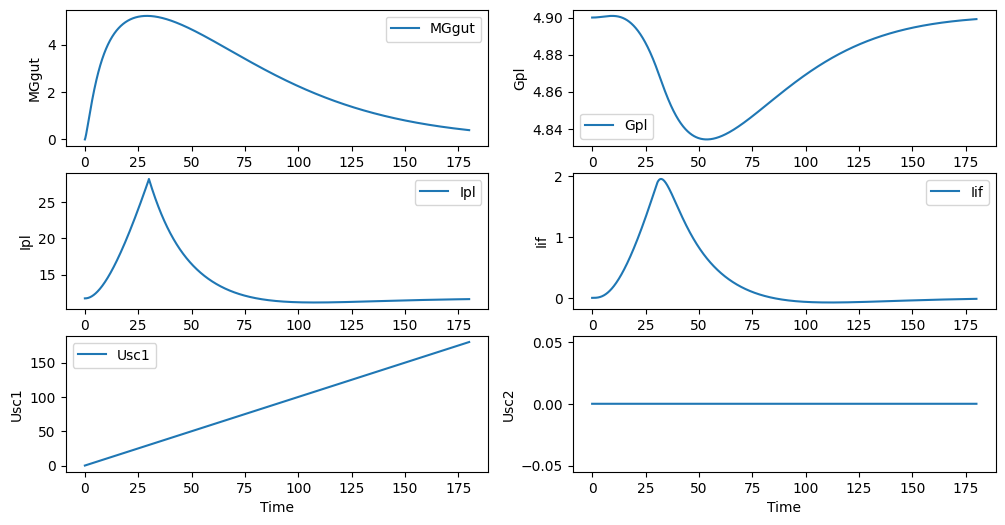

In [76]:
# Plot the results
plt.figure(figsize=(12,6))

plt.subplot(3, 2, 1)
plt.plot(t, MGgut, label='MGgut')
plt.xlabel('Time')
plt.ylabel('MGgut')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(t, Gpl, label='Gpl')
plt.xlabel('Time')
plt.ylabel('Gpl')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(t, Ipl, label='Ipl')
plt.xlabel('Time')
plt.ylabel('Ipl')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(t, Iif, label='Iif')
plt.xlabel('Time')
plt.ylabel('Iif')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(t, Usc1, label='Usc1')
plt.xlabel('Time')
plt.ylabel('Usc1')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(t, Usc2, label='Usc2')
plt.xlabel('Time')
plt.ylabel('Usc2')

plt.show()